In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [5]:
# Load data
obs_files = [
    "./data4/observations_round_4_day_1.csv",
    "./data4/observations_round_4_day_2.csv",
    "./data4/observations_round_4_day_3.csv"
]
price_files = [
    "./data4/prices_round_4_day_1.csv",
    "./data4/prices_round_4_day_2.csv",
    "./data4/prices_round_4_day_3.csv"
]

# Read observations and prices
obs = pd.concat([pd.read_csv(f, delimiter=',') for f in obs_files])
prices = pd.concat([pd.read_csv(f, delimiter=';') for f in price_files])


===== Regression Performance =====
RMSE     : 2.5062
R2 Score : 0.9989

===== Coefficients =====
Intercept: -0.33757232037044105
converted_mid_lag1    : -0.0001
converted_mid_lag2    : 0.0002
converted_mid_lag3    : 0.9990
sugarprice            : 0.0052
sunlightindex         : -0.0025


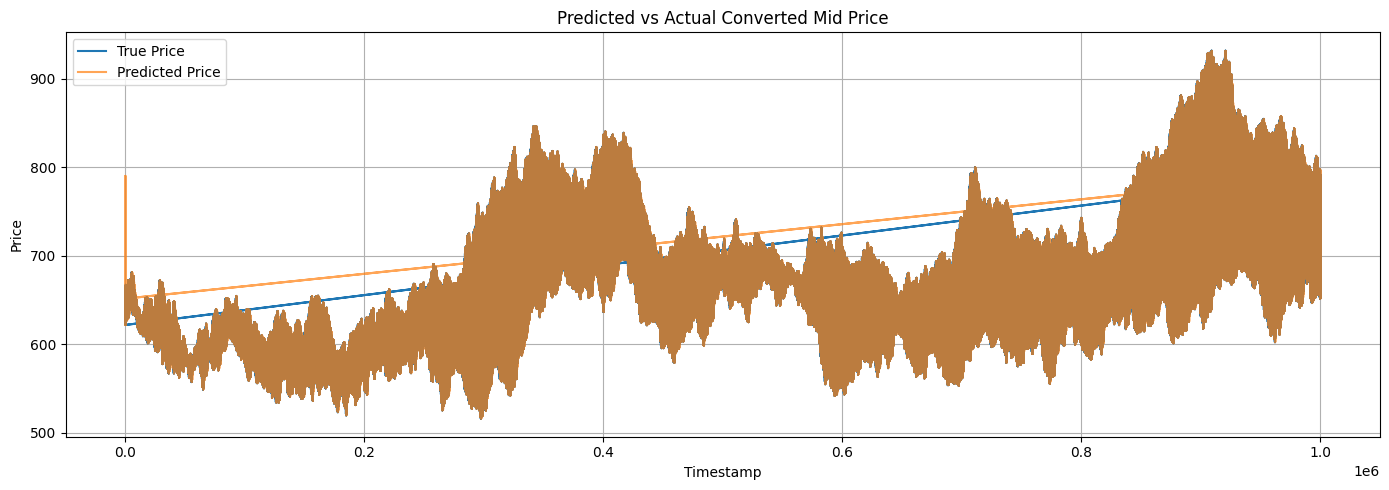

In [14]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load observation data
obs_files = [
    "./data4/observations_round_4_day_1.csv",
    "./data4/observations_round_4_day_2.csv",
    "./data4/observations_round_4_day_3.csv"
]
price_files = [
    "./data4/prices_round_4_day_1.csv",
    "./data4/prices_round_4_day_2.csv",
    "./data4/prices_round_4_day_3.csv"
]

obs = pd.concat([pd.read_csv(f, delimiter=",") for f in obs_files])
prices = pd.concat([pd.read_csv(f, delimiter=";") for f in price_files])

# Only MACARONS
mac = prices[prices["product"] == "MAGNIFICENT_MACARONS"].copy()
mac["mid_price"] = (mac["bid_price_1"] + mac["ask_price_1"]) / 2

# Normalize column names
obs.columns = obs.columns.str.strip().str.lower()
mac.columns = mac.columns.str.strip().str.lower()

# Merge safely
merged = mac.merge(obs, on="timestamp")

# Merge with observations
merged = mac.merge(obs, on="timestamp")

# Compute 'converted mid' price
merged["converted_mid"] = (
    (merged["askprice"] + merged["importtariff"] + merged["transportfees"]) +
    (merged["bidprice"] - merged["exporttariff"] - merged["transportfees"])
) / 2

# Add AR lags
for lag in range(1, 4):
    merged[f"converted_mid_lag{lag}"] = merged["converted_mid"].shift(lag)

merged.dropna(inplace=True)

# Model features
features = [f"converted_mid_lag{i}" for i in range(1, 4)] + ["sugarprice", "sunlightindex"]
X = merged[features]
y = merged["converted_mid"]

# Fit regression model
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# Evaluation
rmse = mean_squared_error(y, y_pred) ** 0.5
r2 = r2_score(y, y_pred)

print("\n===== Regression Performance =====")
print(f"RMSE     : {rmse:.4f}")
print(f"R2 Score : {r2:.4f}")
print("\n===== Coefficients =====")
print("Intercept:", model.intercept_)
for name, coef in zip(features, model.coef_):
    print(f"{name:<22}: {coef:.4f}")

# Plot
plt.figure(figsize=(14, 5))
plt.plot(merged["timestamp"], y, label="True Price")
plt.plot(merged["timestamp"], y_pred, label="Predicted Price", alpha=0.7)
plt.title("Predicted vs Actual Converted Mid Price")
plt.xlabel("Timestamp")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


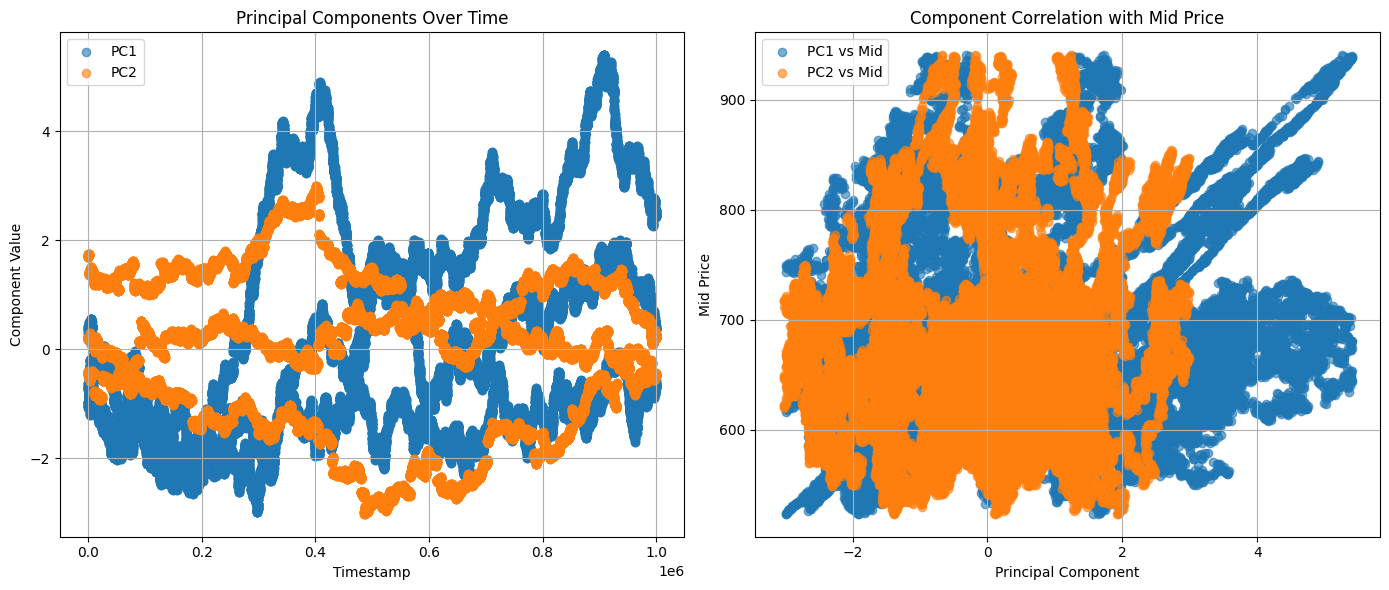

In [17]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load data
obs_files = [
    "./data4/observations_round_4_day_1.csv",
    "./data4/observations_round_4_day_2.csv",
    "./data4/observations_round_4_day_3.csv"
]
price_files = [
    "./data4/prices_round_4_day_1.csv",
    "./data4/prices_round_4_day_2.csv",
    "./data4/prices_round_4_day_3.csv"
]

obs = pd.concat([pd.read_csv(f) for f in obs_files])
prices = pd.concat([pd.read_csv(f, delimiter=";") for f in price_files])

# Normalize column names
obs.columns = obs.columns.str.strip().str.lower()
prices.columns = prices.columns.str.strip().str.lower()

# Focus on macarons only
mac = prices[prices["product"] == "MAGNIFICENT_MACARONS"].copy()
mac["mid_price"] = (mac["bid_price_1"] + mac["ask_price_1"]) / 2

# Merge by timestamp
merged = mac.merge(obs, on="timestamp")

# PCA features (intercepts)
factors = ["sugarprice", "sunlightindex", "bidprice", "askprice", "transportfees", "exporttariff", "importtariff"]
scaler = StandardScaler()
X = scaler.fit_transform(merged[factors])

# PCA analysis
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)

# Add back to DataFrame
merged["PC1"] = pca_result[:, 0]
merged["PC2"] = pca_result[:, 1]

# Plot components over time
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(merged["timestamp"], merged["PC1"], label="PC1", alpha=0.6)
plt.scatter(merged["timestamp"], merged["PC2"], label="PC2", alpha=0.6)
plt.title("Principal Components Over Time")
plt.xlabel("Timestamp")
plt.ylabel("Component Value")
plt.grid(True)
plt.legend()

# Correlation with mid-price
plt.subplot(1, 2, 2)
plt.scatter(merged["PC1"], merged["mid_price"], label="PC1 vs Mid", alpha=0.6)
plt.scatter(merged["PC2"], merged["mid_price"], label="PC2 vs Mid", alpha=0.6)
plt.title("Component Correlation with Mid Price")
plt.xlabel("Principal Component")
plt.ylabel("Mid Price")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


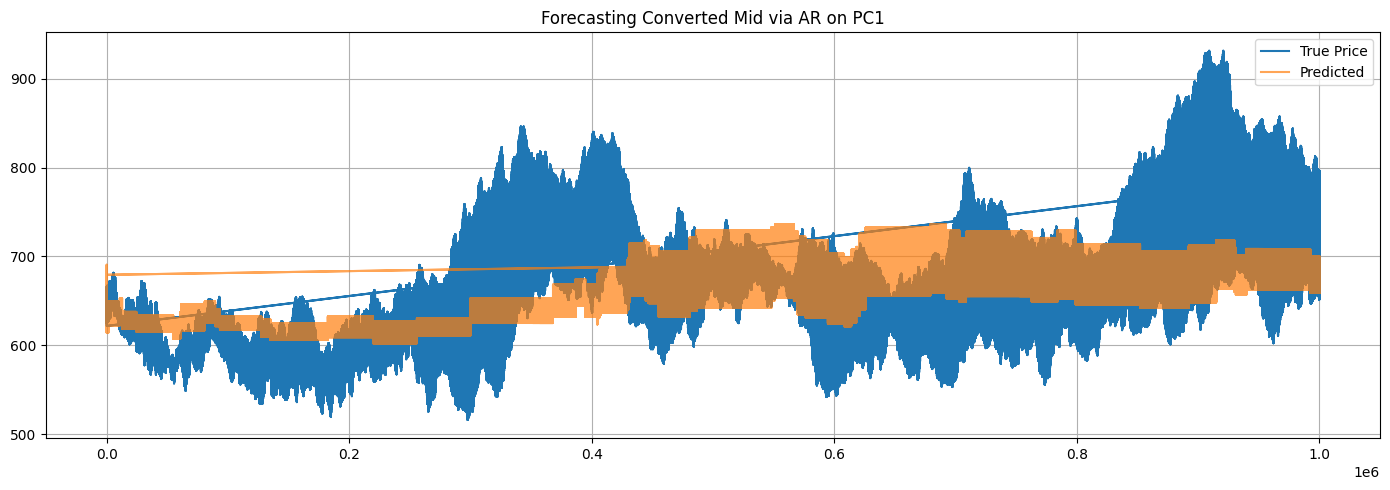

In [18]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Load and combine observation + price files
obs_files = [
    "./data4/observations_round_4_day_1.csv",
    "./data4/observations_round_4_day_2.csv",
    "./data4/observations_round_4_day_3.csv"
]
price_files = [
    "./data4/prices_round_4_day_1.csv",
    "./data4/prices_round_4_day_2.csv",
    "./data4/prices_round_4_day_3.csv"
]

obs = pd.concat([pd.read_csv(f) for f in obs_files])
prices = pd.concat([pd.read_csv(f, delimiter=";") for f in price_files])

# Normalize column names
obs.columns = obs.columns.str.strip().str.lower()
prices.columns = prices.columns.str.strip().str.lower()

# Only look at MACARONS
mac = prices[prices["product"] == "MAGNIFICENT_MACARONS"].copy()
mac["mid_price"] = (mac["bid_price_1"] + mac["ask_price_1"]) / 2

# Merge with observations
merged = mac.merge(obs, on="timestamp")

# Calculate converted mid price
merged["converted_mid"] = (
    (merged["askprice"] + merged["importtariff"] + merged["transportfees"]) +
    (merged["bidprice"] - merged["exporttariff"] - merged["transportfees"])
) / 2

# Keep only necessary columns
merged = merged[[
    "timestamp", "converted_mid", "sugarprice", "sunlightindex",
    "transportfees", "exporttariff", "importtariff"
]]
merged.dropna(inplace=True)

# PCA on intercept-like features
X_pca = merged[["transportfees", "exporttariff", "importtariff"]]
pca = PCA(n_components=1)
merged["PC1"] = pca.fit_transform(X_pca)

# Autoregressive lags of PC1
for lag in range(1, 4):
    merged[f"PC1_lag{lag}"] = merged["PC1"].shift(lag)
merged.dropna(inplace=True)

# Train AR model
X_ar = merged[[f"PC1_lag{i}" for i in range(1, 4)]]
y_ar = merged["converted_mid"]
model_ar = LinearRegression().fit(X_ar, y_ar)
y_pred = model_ar.predict(X_ar)

# Plot
plt.figure(figsize=(14, 5))
plt.plot(merged["timestamp"], y_ar, label="True Price")
plt.plot(merged["timestamp"], y_pred, label="Predicted", alpha=0.7)
plt.legend()
plt.title("Forecasting Converted Mid via AR on PC1")
plt.grid(True)
plt.tight_layout()
plt.show()


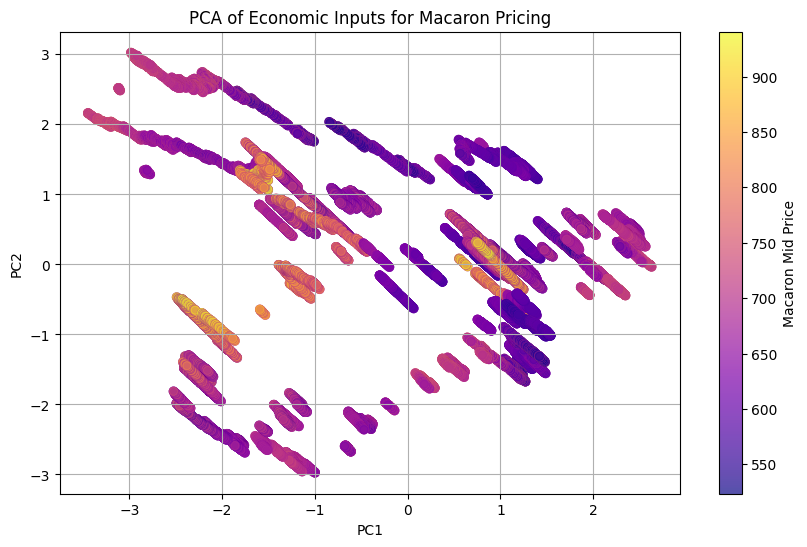

Explained Variance by Component: [0.44550191 0.32209059]


In [20]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load your CSVs (update paths as needed)
obs_files = [
    "./data4/observations_round_4_day_1.csv",
    "./data4/observations_round_4_day_2.csv",
    "./data4/observations_round_4_day_3.csv"
]
price_files = [
    "./data4/prices_round_4_day_1.csv",
    "./data4/prices_round_4_day_2.csv",
    "./data4/prices_round_4_day_3.csv"
]
# Load and merge data
obs = pd.concat([pd.read_csv(f) for f in obs_files])
prices = pd.concat([pd.read_csv(f, delimiter=";") for f in price_files])

# Normalize columns
obs.columns = obs.columns.str.strip().str.lower()
prices.columns = prices.columns.str.strip().str.lower()

# Get macaron mid-prices
mac = prices[prices["product"] == "MAGNIFICENT_MACARONS"].copy()
mac["mid_price"] = (mac["bid_price_1"] + mac["ask_price_1"]) / 2
mac = mac[["timestamp", "mid_price"]]

# Merge on timestamp
merged = pd.merge(obs, mac, on="timestamp", how="inner")

# Select features
factors = ["transportfees", "exporttariff", "importtariff", "sugarprice", "sunlightindex"]
X = merged[factors]

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA
pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)

# Frame with results
pca_df = pd.DataFrame(data=components, columns=["PC1", "PC2"])
pca_df["mid_price"] = merged["mid_price"].values

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(pca_df["PC1"], pca_df["PC2"], c=pca_df["mid_price"], cmap='plasma', alpha=0.7)
plt.colorbar(label="Macaron Mid Price")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of Economic Inputs for Macaron Pricing")
plt.grid(True)
plt.show()

# Print explained variance
print("Explained Variance by Component:", pca.explained_variance_ratio_)


/var/folders/4r/dygtxtn155l8zwg6_s8jtpw80000gn/T/ipykernel_15469/133540106.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = merged.groupby("sun_bin")["mid_price"].mean()
/var/folders/4r/dygtxtn155l8zwg6_s8jtpw80000gn/T/ipykernel_15469/133540106.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_centers = merged.groupby("sun_bin")["sunlightindex"].mean()


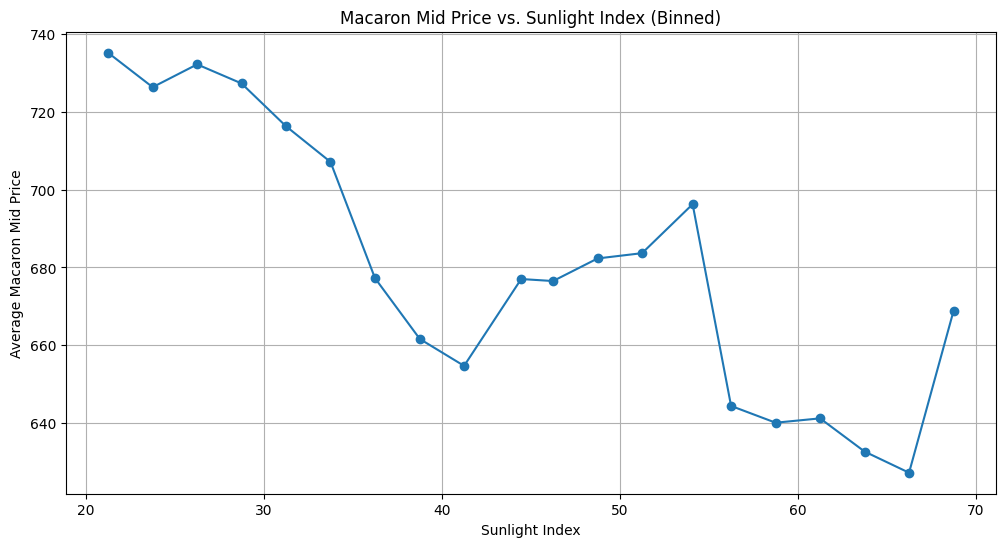

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data
obs_files = [
    "./data4/observations_round_4_day_1.csv",
    "./data4/observations_round_4_day_2.csv",
    "./data4/observations_round_4_day_3.csv"
]
price_files = [
    "./data4/prices_round_4_day_1.csv",
    "./data4/prices_round_4_day_2.csv",
    "./data4/prices_round_4_day_3.csv"
]

obs = pd.concat([pd.read_csv(f) for f in obs_files])
prices = pd.concat([pd.read_csv(f, delimiter=";") for f in price_files])

# Filter macaron prices and compute mid
mac = prices[prices["product"] == "MAGNIFICENT_MACARONS"].copy()
mac["mid_price"] = (mac["bid_price_1"] + mac["ask_price_1"]) / 2

# Normalize column names
obs.columns = obs.columns.str.strip().str.lower()
mac.columns = mac.columns.str.strip().str.lower()

# Merge
merged = mac.merge(obs, on="timestamp")

# Bin the sunlight index
merged["sun_bin"] = pd.cut(merged["sunlightindex"], bins=20)

# Group by sunlight bin and get average mid price
bin_means = merged.groupby("sun_bin")["mid_price"].mean()
bin_centers = merged.groupby("sun_bin")["sunlightindex"].mean()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(bin_centers, bin_means, marker='o', linestyle='-')
plt.title("Macaron Mid Price vs. Sunlight Index (Binned)")
plt.xlabel("Sunlight Index")
plt.ylabel("Average Macaron Mid Price")
plt.grid(True)
plt.show()


RMSE: 4.5803
R^2 Score: 0.9962


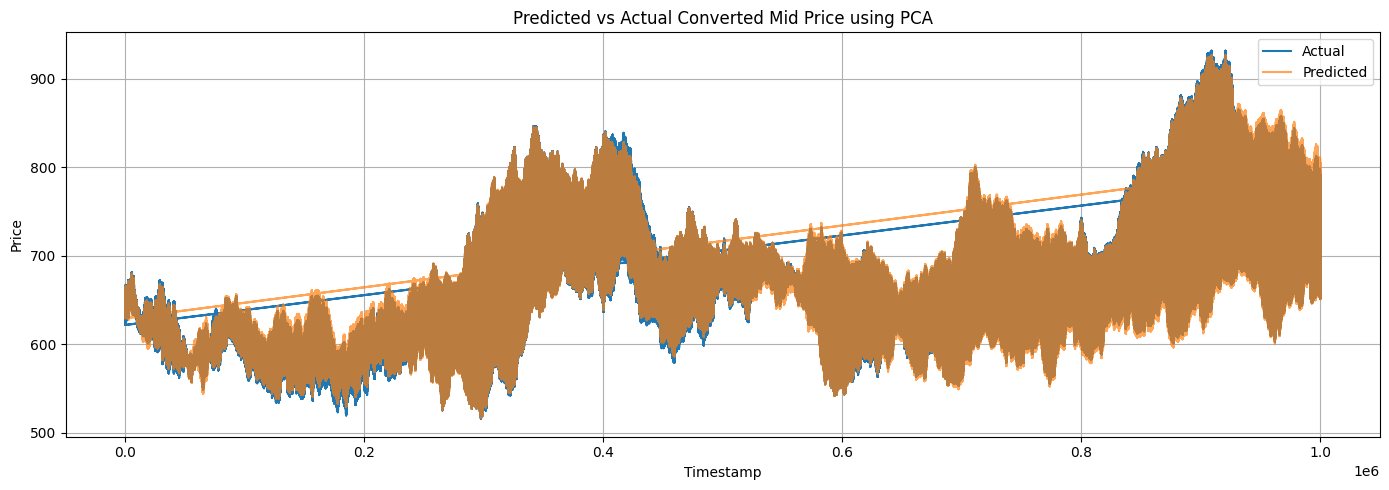

In [23]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load data
obs_files = [
    "./data4/observations_round_4_day_1.csv",
    "./data4/observations_round_4_day_2.csv",
    "./data4/observations_round_4_day_3.csv"
]
price_files = [
    "./data4/prices_round_4_day_1.csv",
    "./data4/prices_round_4_day_2.csv",
    "./data4/prices_round_4_day_3.csv"
]

obs = pd.concat([pd.read_csv(f) for f in obs_files])
prices = pd.concat([pd.read_csv(f, delimiter=";") for f in price_files])

# Normalize columns
obs.columns = obs.columns.str.strip().str.lower()
prices.columns = prices.columns.str.strip().str.lower()

# MACARONS only
mac = prices[prices["product"] == "MAGNIFICENT_MACARONS"].copy()
mac["mid_price"] = (mac["bid_price_1"] + mac["ask_price_1"]) / 2
mac = mac[["timestamp", "mid_price"]]

# Merge and compute converted mid
merged = mac.merge(obs, on="timestamp")
merged["converted_mid"] = (
    (merged["askprice"] + merged["importtariff"] + merged["transportfees"]) +
    (merged["bidprice"] - merged["exporttariff"] - merged["transportfees"])
) / 2

# PCA on intercept-like features
features = ["bidprice", "askprice", "transportfees", "exporttariff", "importtariff"]
X = merged[features]
y = merged["converted_mid"]

# Standardize and PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

# Regression
model = LinearRegression()
model.fit(X_pca, y)
y_pred = model.predict(X_pca)

# Evaluation
rmse = np.sqrt(mean_squared_error(y, y_pred))
r2 = r2_score(y, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"R^2 Score: {r2:.4f}")

# Visualization
plt.figure(figsize=(14, 5))
plt.plot(merged["timestamp"], y, label="Actual")
plt.plot(merged["timestamp"], y_pred, label="Predicted", alpha=0.7)
plt.title("Predicted vs Actual Converted Mid Price using PCA")
plt.xlabel("Timestamp")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [24]:
print("FEATURE MEANS:")
print(scaler.mean_)

print("FEATURE STDS:")
print(scaler.scale_)

print("PCA COMPONENTS:")
print(pca.components_)

print("LINEAR REGRESSION COEFFICIENTS:")
print(model.coef_)

print("LINEAR REGRESSION INTERCEPT:")
print(model.intercept_)

FEATURE MEANS:
[662.88011667 664.39493333   1.57758667  10.1648      -3.67778333]
FEATURE STDS:
[74.54337341 74.54442441  0.37497508  0.68696746  1.11103619]
PCA COMPONENTS:
[[ 0.54886044  0.54886038 -0.12139105  0.36690067 -0.49814919]
 [-0.35873429 -0.3587351   0.40257862  0.63523918 -0.42073802]
 [ 0.23016567  0.23016426  0.9071368  -0.24486907  0.1057835 ]]
LINEAR REGRESSION COEFFICIENTS:
[ 40.51143957 -27.19340454  17.30026718]
LINEAR REGRESSION INTERCEPT:
656.7162333333332


KeyError: "None of [Index(['transportFees', 'exportTariff', 'importTariff'], dtype='object')] are in the [columns]"

In [ ]:
import numpy as np

# Feature scaling parameters
feature_means = np.array([662.88011667, 664.39493333, 1.57758667, 10.1648, -3.67778333])
feature_stds = np.array([74.54337341, 74.54442441, 0.37497508, 0.68696746, 1.11103619])

# PCA components (3 components x 5 features)
pca_components = np.array([
    [0.54886044,  0.54886038, -0.12139105,  0.36690067, -0.49814919],
    [-0.35873429, -0.3587351,  0.40257862,  0.63523918, -0.42073802],
    [0.23016567,  0.23016426,  0.9071368,  -0.24486907,  0.1057835]
])

# Linear regression coefficients and intercept in PCA space
regression_weights = np.array([40.51143957, -27.19340454, 17.30026718])
regression_intercept = 656.7162333333332

def predict_macaron_price(raw_features):
    """
    raw_features: [askPrice, bidPrice, sugarPrice, sunlightIndex, netTariff]
    Returns: predicted macaron fair price using PCA + regression
    """
    # Standardize
    scaled = (np.array(raw_features) - feature_means) / feature_stds

    # Project to PCA space
    principal_components = pca_components @ scaled

    # Linear regression prediction in PCA space
    prediction = np.dot(principal_components, regression_weights) + regression_intercept
    return prediction

# Example usage:
example = [650, 660, 1.5, 10.5, -3.2]
predicted_price = predict_macaron_price(example)
predicted_price
